In [321]:
import warnings

import numpy as np
import pandas as pd
import statsmodels.graphics.tsaplots as sgt
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial as poly
from scipy.optimize import minimize
from scipy.stats import t as students_t, pearsonr
from statsmodels.tsa.arima.model import ARIMA

from tsa import config

In [322]:
np.random.seed(42)

In [323]:
def plot_hist(x, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(x_t)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# 1.
Generate a hypothetical time series for $t = 1, · · · , 1000$ using the following specifications. For each specification, plot the hypothetical series; compute the theoretical mean, variance, and first-order autocorrelation; and compare with their sample counterparts.

### (a) $x_t = 0.3 + 0.85x_{t−1} + \epsilon_t$, where $\epsilon_t ∼ N(0, 1)$

In [324]:
e = np.random.normal(0, 1, 1000)
x_t = np.zeros(1000)
for i in range(1, 1000):
    x_t[i] = 0.3 + 0.85 * x_t[i - 1] + e[i]

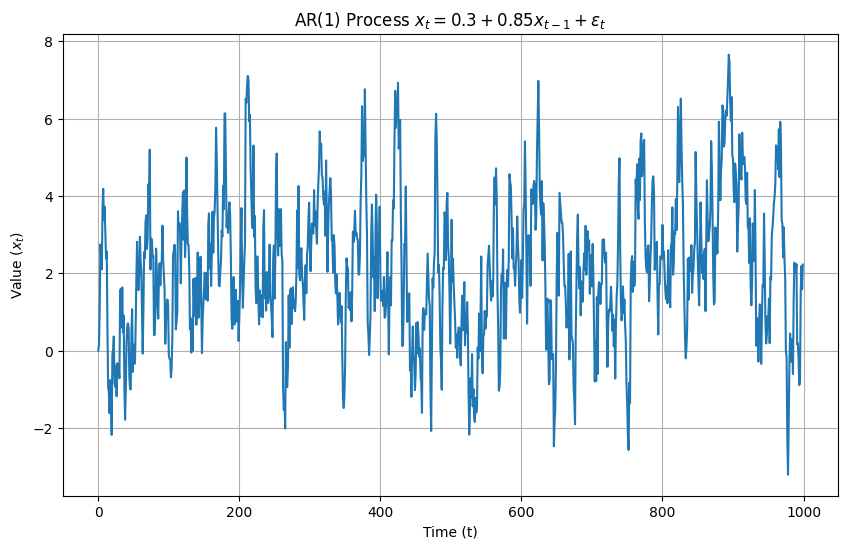

In [325]:
plot_hist(
    x_t,
    "AR(1) Process $x_t = 0.3 + 0.85x_{t-1} + \epsilon_t$",
    "Time (t)",
    "Value ($x_t$)",
)

In [326]:
sample_mean = np.mean(x_t)
sample_var = np.var(x_t)
sample_autocor = np.corrcoef(x_t[:-1], x_t[1:])[0, 1]

theoretical_mean = 0.3 / (1 - 0.85)
theoretical_var = 1 / (1 - 0.85**2)
theoretical_autocor = 0.85

print(f"Sample Mean: {sample_mean:.4f}, Theoretical Mean: {theoretical_mean:.4f}")
print(f"Sample Variance: {sample_var:.4f}, Theoretical Variance: {theoretical_var:.4f}")
print(
    f"Sample Autocorrelation: {sample_autocor:.4f}, Theoretical Autocorrelation: {theoretical_autocor:.4f}"
)

Sample Mean: 2.1110, Theoretical Mean: 2.0000
Sample Variance: 3.4168, Theoretical Variance: 3.6036
Sample Autocorrelation: 0.8482, Theoretical Autocorrelation: 0.8500


### (b) $y_t = 0.8 + ϵ_t + 1.2ϵ_{t−1}$, where $ϵ_t ∼ N(0, 0.1)$

In [327]:
# MA(1) process
e = np.random.normal(0, 0.1**0.5, 1000)
x_t = np.zeros(1000)
for i in range(1, 1000):
    x_t[i] = 0.8 + e[i] + 1.2 * e[i - 1]

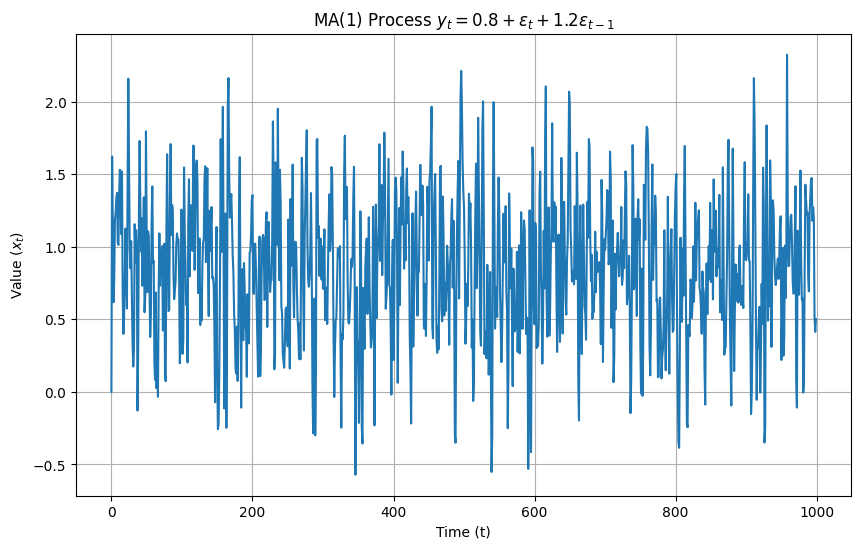

In [328]:
plot_hist(
    x_t,
    "MA(1) Process $y_t = 0.8 + \epsilon_t + 1.2\epsilon_{t−1}$",
    "Time (t)",
    "Value ($x_t$)",
)

In [329]:
sample_mean = np.mean(x_t)
sample_var = np.var(x_t)
sample_autocor = np.corrcoef(x_t[:-1], x_t[1:])[0, 1]

theoretical_mean = 0.8
theoretical_var = 0.1 * (1 + 1.2**2)
theoretical_autocor = 1.2 / (1 + 1.2**2)

print(f"Sample Mean: {sample_mean:.4f}, Theoretical Mean: {theoretical_mean:.4f}")
print(f"Sample Variance: {sample_var:.4f}, Theoretical Variance: {theoretical_var:.4f}")
print(
    f"Sample Autocorrelation: {sample_autocor:.4f}, Theoretical Autocorrelation: {theoretical_autocor:.4f}"
)

Sample Mean: 0.8483, Theoretical Mean: 0.8000
Sample Variance: 0.2396, Theoretical Variance: 0.2440
Sample Autocorrelation: 0.4741, Theoretical Autocorrelation: 0.4918


## 2.
Are the following AR processes stationary? Find the roots of the characteristic equation.

In order to determine wether the AR process is staitonary, we use the characteristic equation and test if all roots lie inside the unit circle.

In [330]:
def calculate_roots(coefficients):
    polyroots = poly.polyroots(coefficients)
    print(f"The roots are: {polyroots}")
    return polyroots


def check_stationarity(roots):
    if np.all(np.abs(roots) < 1):
        print(
            "\nConclusion: The process is STATIONARY because all roots are inside the unit circle."
        )
    else:
        print(
            "\nConclusion: The process is NOT STATIONARY because at least one root is on or outside the unit circle."
        )

### (a) $y_t = 0.7y_{t−1} + 0.2y_{t−2} + \epsilon_t$

In [331]:
roots = calculate_roots([-0.2, -0.7, 1])

check_stationarity(roots)

The roots are: [-0.21789083  0.91789083]

Conclusion: The process is STATIONARY because all roots are inside the unit circle.


### (b) $y_t = 0.7y_{t−1} + 0.301y_{t−2} + \epsilon_t$


In [332]:
roots = calculate_roots([-0.301, -0.7, 1])

check_stationarity(roots)

The roots are: [-0.30076878  1.00076878]

Conclusion: The process is NOT STATIONARY because at least one root is on or outside the unit circle.


### (c) $y_t = 0.6y_{t−1} - 0.4y_{t−2} + 0.5y_{t−3} + 0.4y_{t−4} + \epsilon_t$

In [333]:
roots = calculate_roots([-0.4, -0.5, 0.4, -0.6, 1])

check_stationarity(roots)

The roots are: [-0.44894023+0.j          0.00579008-0.92674978j  0.00579008+0.92674978j
  1.03736008+0.j        ]

Conclusion: The process is NOT STATIONARY because at least one root is on or outside the unit circle.


### (d) $y_t = 1.1y_{t−1} - 0.47y_{t−2} + 0.44y_{t−3} - 0.32y_{t−4} + 0.29y_{t-5} - 0.38y_{t-6} + 0.17y_{t-7} + \epsilon_t$

In [334]:
roots = calculate_roots([-0.17, 0.38, -0.29, 0.32, -0.44, 0.47, -1.1, 1])

check_stationarity(roots)

The roots are: [-0.59749801-0.53913641j -0.59749801+0.53913641j  0.08027147-0.79043564j
  0.08027147+0.79043564j  0.68354684-0.27321663j  0.68354684+0.27321663j
  0.76735939+0.j        ]

Conclusion: The process is STATIONARY because all roots are inside the unit circle.


## 3.


In [335]:
df_gs10 = pd.read_csv(
    config.EXTERNAL_DATA_DIR / "GS10.csv",
    parse_dates=["observation_date"],
    index_col="observation_date",
)
df_tb3ms = pd.read_csv(
    config.EXTERNAL_DATA_DIR / "TB3MS.csv",
    parse_dates=["observation_date"],
    index_col="observation_date",
).sort_values("observation_date")

### (a) Construct and plot the interest rate spread, which is defined as (`GS10 - TB3MS`).

In [336]:
df = pd.merge(df_gs10, df_tb3ms, on="observation_date", how="inner")

In [337]:
df["spread"] = df["GS10"] - df["TB3MS"]

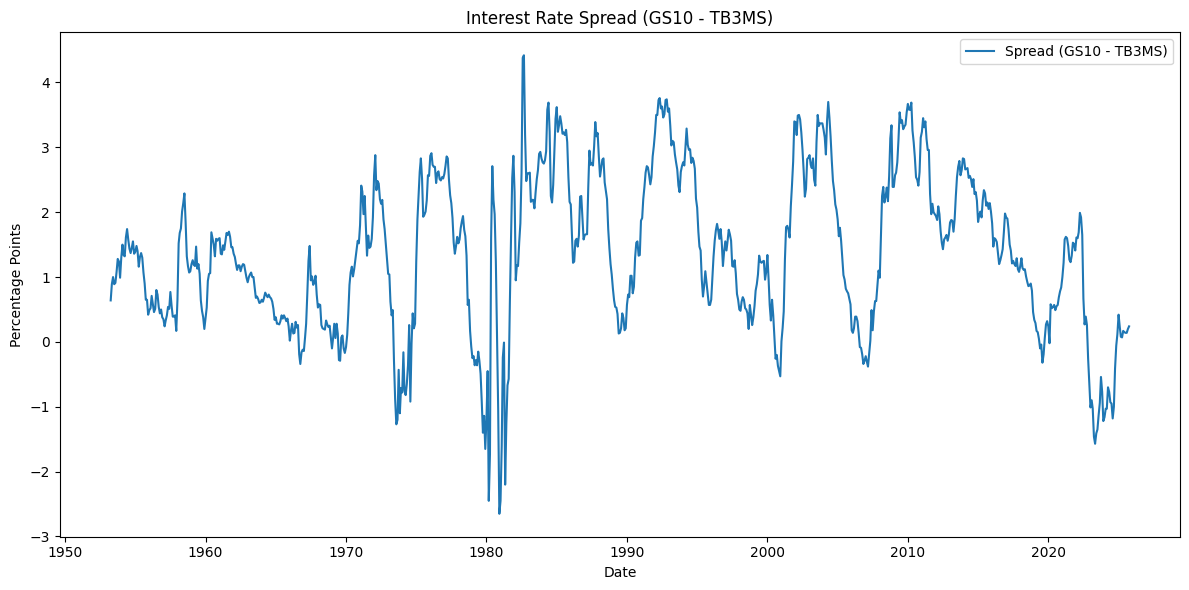

In [338]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["spread"], label="Spread (GS10 - TB3MS)")
plt.title("Interest Rate Spread (GS10 - TB3MS)")
plt.xlabel("Date")
plt.ylabel("Percentage Points")
plt.legend()
plt.tight_layout()
plt.show()

### (b) Calculate the autocorrelation and partial autocorrelation functions of the spread.

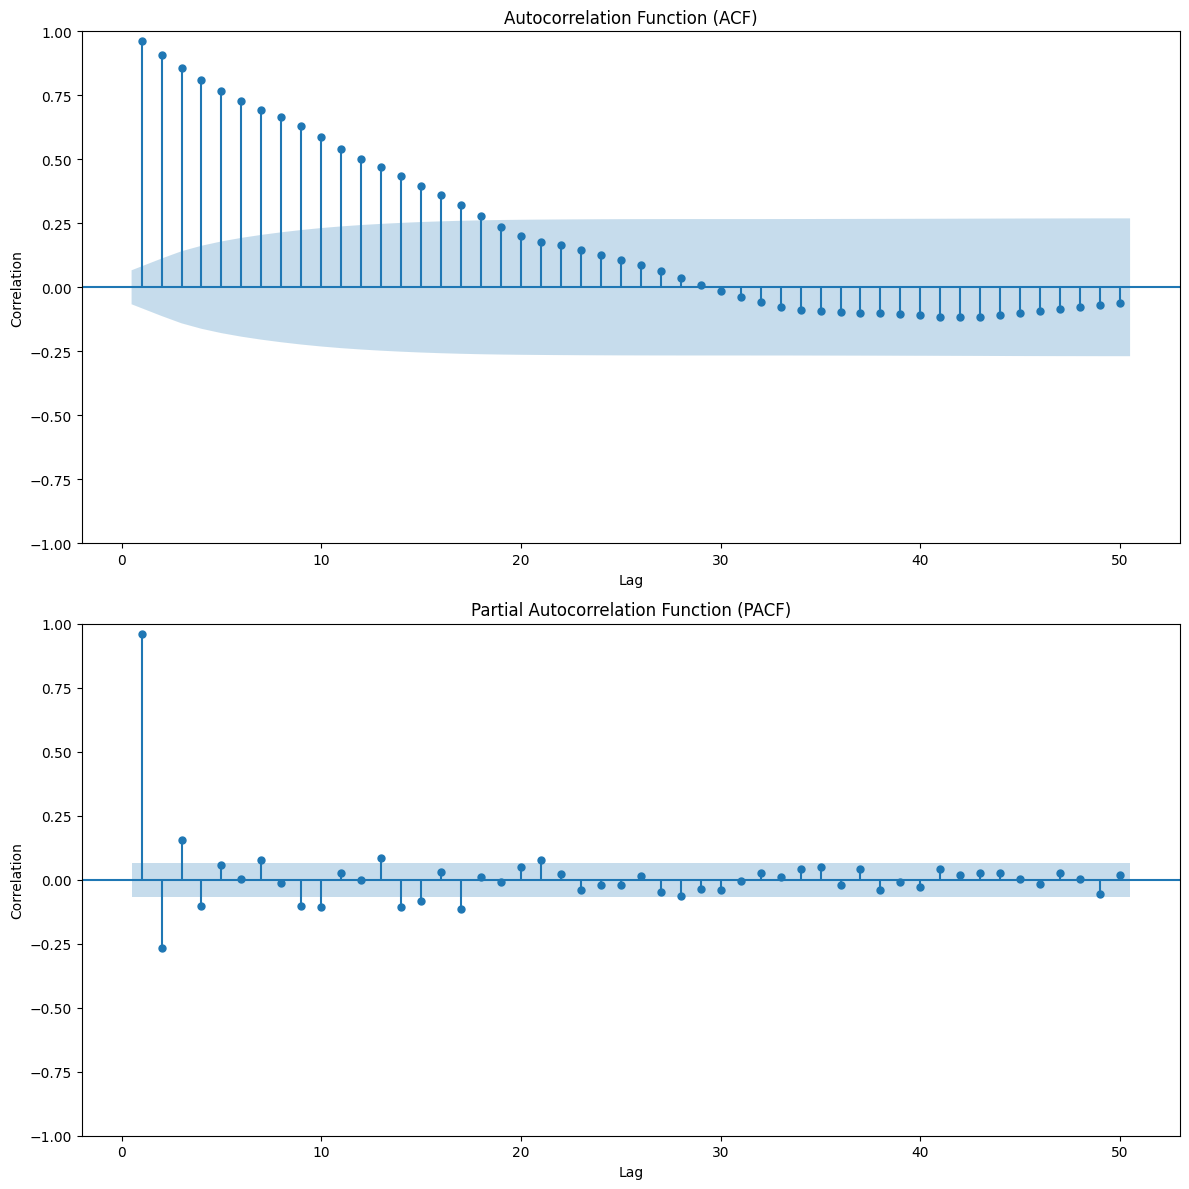

In [339]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Correlation")
sgt.plot_acf(df["spread"], ax=axes[0], lags=50, zero=False)
axes[0].set_title("Autocorrelation Function (ACF)")

axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Correlation")
sgt.plot_pacf(df["spread"], ax=axes[1], lags=50, zero=False)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

### (c) Consider `ARMA(p, q)` model for the spread, where $p$ and $q$ can be zero. What is the best model for describing the interest rate spread movement over time? Report the estimation results. Provide reasonings/justifications for your choice.

By looking at the subplots from (b), we can use the Box-Jenkins approach to make a first estimate on which model might perform best. It looks like a AR(p) model would work the best, since the ACF is decaying, and the PACF spikes at Lag 1 and then oscillates around 0. To confirm this initial guesstimate, we will also test different models AIC and BIC:

In [340]:
warnings.filterwarnings("ignore")

results = []
max_p = 4
max_q = 4

for p in range(max_p + 1):
    for q in range(max_q + 1):
        model = ARIMA(df["spread"], order=(p, 0, q), freq="MS")
        res = model.fit()

        results.append({"p": p, "q": q, "AIC": res.aic, "BIC": res.bic})


results_df = pd.DataFrame(results)

best_bic = results_df.loc[results_df["BIC"].idxmin()]
best_aic = results_df.loc[results_df["AIC"].idxmin()]

print("--- Model Selection Results (Lowest is Best) ---")
print(results_df.to_string())

print(
    f"\nBest Model by BIC: p={int(best_bic['p'])}, q={int(best_bic['q'])} (BIC: {best_bic['BIC']:.2f})"
)
print(
    f"Best Model by AIC: p={int(best_aic['p'])}, q={int(best_aic['q'])} (AIC: {best_aic['AIC']:.2f})"
)

best_p = int(best_bic["p"])
best_q = int(best_bic["q"])

print(f"\n--- ESTIMATION RESULTS FOR ARMA({best_p}, {best_q}) ---")
best_model = ARIMA(df["spread"], order=(best_p, 0, best_q), freq="MS")
best_res = best_model.fit()

print(best_res.summary())

--- Model Selection Results (Lowest is Best) ---
    p  q          AIC          BIC
0   0  0 2,799.588806 2,809.128090
1   0  1 1,783.356494 1,797.665420
2   0  2 1,232.077326 1,251.155894
3   0  3   947.349074   971.197284
4   0  4   803.436628   832.054480
5   1  0   528.036047   542.344973
6   1  1   436.673549   455.752117
7   1  2   429.281570   453.129779
8   1  3   430.245246   458.863098
9   1  4   432.224441   465.611935
10  2  0   463.850976   482.929544
11  2  1   428.191361   452.039571
12  2  2   430.135579   458.753431
13  2  3   431.724012   465.111506
14  2  4   434.044748   472.201883
15  3  0   443.153961   467.002170
16  3  1   430.142448   458.760299
17  3  2   432.143682   465.531175
18  3  3   433.739840   471.896975
19  3  4   436.150152   479.076930
20  4  0   435.119833   463.737685
21  4  1   432.067974   465.455468
22  4  2   434.100527   472.257663
23  4  3   426.037165   468.963943
24  4  4   422.497400   470.193819

Best Model by BIC: p=2, q=1 (BIC: 452.04

Based on our analysis, the ARMA(2, 1) model provides the best description of the interest rate spread, as it yielded the lowest BIC (452.040) among all tested models. The final estimated equation has highly significant coefficients for its AR and MA terms, and its residuals are indistinguishable from white noise, confirming a robust model fit.

### (d) Consider `AR(4)` and `ARMA(2,1)` models. Keep the latest 50 observations for the pseudo out-of-sample forecasting exercise. Use the remaining observations to estimate the above models. Compute MSPE over 50 1-step-ahead forecasts and perform the Granger-Newbold test for equal predictability for the spread. Explain the result

In [341]:
def step_ahead_forecast(train, test, m: ARIMA, m_order: tuple):
    history = list(train)
    pred = []
    for i in range(len(test)):
        model = m(history, order=m_order)
        res = model.fit()
        y_hat = res.forecast()[0]
        pred.append(y_hat)
        history.append(test.iloc[i])
    return pred

In [342]:
spread = df["spread"]
train_size = len(spread) - 50
train, test = spread[0:train_size], spread[train_size:]

forecast_ar4 = step_ahead_forecast(train, test, ARIMA, (4, 0, 0))
errors_ar4 = test - forecast_ar4

forecast_arma21 = step_ahead_forecast(train, test, ARIMA, (2, 0, 1))
errors_arma21 = test - forecast_arma21

In [343]:
mspe_ar4 = np.mean(errors_ar4**2)
mspe_arma21 = np.mean(errors_arma21**2)

print(f"--- Forecast Accuracy ---")
print(f"MSPE for AR(4): {mspe_ar4:.4f}")
print(f"MSPE for ARMA(2,1): {mspe_arma21:.4f}")

--- Forecast Accuracy ---
MSPE for AR(4): 0.0630
MSPE for ARMA(2,1): 0.0626


Granger-Newbold Test:

$$T = \frac{r_{xz}}{\sqrt{(1 - (r_{xz})^2) / (H - 1)}}$$
$$r_{xz} \times \left( \frac{\sqrt{H - 1}}{\sqrt{1 - (r_{xz})^2}} \right)$$
$$r_{xz} \sqrt{\frac{H - 1}{1 - (r_{xz})^2}}$$

In [349]:
d = errors_ar4 - errors_arma21
s = errors_ar4 + errors_arma21

corr, _ = pearsonr(d, s)
n = len(d)
dof = n-1
gn_stat = corr * np.sqrt(dof / (1 - corr**2))
p_value = students_t.sf(np.abs(gn_stat), df=dof) * 2

print("--- Granger-Newbold Test for Equal Predictability ---")
print(
    f"Null Hypothesis: The two models have equal predictive ability (MSPEs are equal)."
)
print(f"Test Statistic: {gn_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis at the 5% significance level.")
    print(
        "There is a statistically significant difference in the predictive ability of the two models."
    )
    if mspe_ar4 < mspe_arma21:
        print("The AR(4) model provides significantly better forecasts.")
    else:
        print("The ARMA(2,1) model provides significantly better forecasts.")
else:
    print(
        "\nConclusion: Fail to reject the null hypothesis at the 5% significance level."
    )
    print(
        "There is no statistically significant difference in the predictive ability of the two models."
    )

--- Granger-Newbold Test for Equal Predictability ---
Null Hypothesis: The two models have equal predictive ability (MSPEs are equal).
Test Statistic: 0.0294
P-value: 0.9766

Conclusion: Fail to reject the null hypothesis at the 5% significance level.
There is no statistically significant difference in the predictive ability of the two models.


## 4.

### (a) Analytically compute $μ ≡ E[y_t]$.

Given the process: $$y_t = a_0 + a_1y_{t−1} + a_2y_{t−2} + \epsilon_t + \beta_1\epsilon_{t−1}$$
To find the unconditional mean μ, we take the expectation of both sides of the equation: $$E[y_t] = E[a_0 + a_1y_{t−1} + a_2y_{t−2} + \epsilon_t + \beta_1\epsilon_{t−1}]$$
Using the linearity of the expectation operator:
$$E[y_t] = E[a_0] + a_1E[y_{t−1}] + a_2E[y_{t−2}] + E[\epsilon_t] + \beta_1E[\epsilon_{t−1}]$$
Since the process is stationary, its mean is constant over time. Let's denote this mean as μ: $$E[y_t] = E[y_{t−1}] = E[y_{t−2}] = \mu$$
Also, since $\epsilon_t$ is a white-noise process, its mean is zero for all time periods: $$E[\epsilon_t] = E[\epsilon_{t−1}] = 0$$
Substituting these back into the equation:
$$\mu = a_0 + a_1\mu + a_2\mu + 0 + 0$$
Now, we can solve for μ:
$$\mu - a_1\mu - a_2\mu = a_0$$ $$\mu(1 - a_1 - a_2) = a_0$$
This gives the final expression for the mean: $\mu = \frac{a_0}{1 - a_1 - a_2}$.

### (b) Derive $γ_k ≡ E[(y_t − μ)(y_{t−k} − μ)]$ for $k = 0, 1, 2, 3$.

sLet $\mu = E[y_t]$. We first define the mean-centered process as $\tilde{y}_t = y_t - \mu$.
The process can be rewritten in terms of $\tilde{y}_t$:
$$\tilde{y}_t = a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1}$$

We are solving for $\gamma_k \equiv E[\tilde{y}_t \tilde{y}_{t-k}]$.

#### Key Properties:

To solve this, we need 3 main properties based on $\epsilon_t$ being a white-noise process and $E[\tilde{y}_{t-k}\epsilon_t] = 0$ for $k > 0$:
1. $$E[\tilde{y}_t \epsilon_t]
= E[(a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1}) \cdot \epsilon_t] = \sigma^2$$
2. $$E[\tilde{y}_t \epsilon_{t-1}] = E[(a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1}) \cdot \epsilon_{t-1}]$$
$$= a_1 E[\tilde{y}_{t-1}\epsilon_{t-1}] + \beta_1 E[\epsilon_{t-1}^2]$$
$$= a_1 \sigma^2 + \beta_1 \sigma^2 = (a_1 + \beta_1)\sigma^2$$
3. This is the same as property 1, just lagged.
$$E[\tilde{y}_{t-1} \epsilon_{t-1}] = \sigma^2$$

#### Derivations for k = 0, 1, 2, 3

Derivation for k = 0 (Variance):

$$\gamma_0 = E[\tilde{y}_t \cdot \tilde{y}_t]$$
$$\gamma_0 = E[\tilde{y}_t \cdot (a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1})]$$
$$\gamma_0 = a_1 E[\tilde{y}_t \tilde{y}_{t-1}] + a_2 E[\tilde{y}_t \tilde{y}_{t-2}] + E[\tilde{y}_t \epsilon_t] + \beta_1 E[\tilde{y}_t \epsilon_{t-1}]$$
$$\gamma_0 = a_1 \gamma_1 + a_2 \gamma_2 + \sigma^2 + \beta_1 ( (a_1 + \beta_1)\sigma^2 )$$
$$\gamma_0 = a_1 \gamma_1 + a_2 \gamma_2 + \sigma^2 (1 + a_1 \beta_1 + \beta_1^2)$$

Derivation for k = 1:

$$\gamma_1 = E[\tilde{y}_t \cdot \tilde{y}_{t-1}]$$
$$\gamma_1 = E[(a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1}) \cdot \tilde{y}_{t-1}]$$
$$\gamma_1 = a_1 E[\tilde{y}_{t-1} \tilde{y}_{t-1}] + a_2 E[\tilde{y}_{t-2} \tilde{y}_{t-1}] + E[\epsilon_t \tilde{y}_{t-1}] + \beta_1 E[\epsilon_{t-1} \tilde{y}_{t-1}]$$
$$\gamma_1 = a_1 \gamma_0 + a_2 \gamma_1 + 0 + \beta_1 (\sigma^2)$$
$$\gamma_1 = a_1 \gamma_0 + a_2 \gamma_1 + \beta_1 \sigma^2$$

Derivation for k = 2:

For $k \ge 2$, the MA term $\beta_1 \epsilon_{t-1}$ is no longer correlated with $\tilde{y}_{t-k}$, so the standard Yule-Walker equations for an AR(2) process apply.
$$\gamma_2 = E[\tilde{y}_t \cdot \tilde{y}_{t-2}]$$
$$\gamma_2 = E[(a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1}) \cdot \tilde{y}_{t-2}]$$
$$\gamma_2 = a_1 E[\tilde{y}_{t-1} \tilde{y}_{t-2}] + a_2 E[\tilde{y}_{t-2} \tilde{y}_{t-2}] + E[\epsilon_t \tilde{y}_{t-2}] + \beta_1 E[\epsilon_{t-1} \tilde{y}_{t-2}]$$
$$\gamma_2 = a_1 \gamma_1 + a_2 \gamma_0 + 0 + 0$$
$$\gamma_2 = a_1 \gamma_1 + a_2 \gamma_0$$

Derivation for k = 3:

The Yule-Walker equation continues to hold for $k \ge 2$.
$$\gamma_3 = E[\tilde{y}_t \cdot \tilde{y}_{t-3}]$$
$$\gamma_3 = E[(a_1 \tilde{y}_{t-1} + a_2 \tilde{y}_{t-2} + \epsilon_t + \beta_1 \epsilon_{t-1}) \cdot \tilde{y}_{t-3}]$$
$$\gamma_3 = a_1 E[\tilde{y}_{t-1} \tilde{y}_{t-3}] + a_2 E[\tilde{y}_{t-2} \tilde{y}_{t-3}] + E[\epsilon_t \tilde{y}_{t-3}] + \beta_1 E[\epsilon_{t-1} \tilde{y}_{t-3}]$$
$$\gamma_3 = a_1 \gamma_2 + a_2 \gamma_1 + 0 + 0$$
$$\gamma_3 = a_1 \gamma_2 + a_2 \gamma_1$$

## 5.)

### (a)

In [345]:
def function_a(x):
    x1, x2 = x
    return (1 - x1) ** 2 + 100 * (x2 - x1**2) ** 2


def minimize_function_a(initial_guess):
    y = minimize(function_a, initial_guess)
    print(f"\nInitial Guess: {x0_1}")
    print(f"Converged: {y.success}")
    print(f"Solution (x1, x2): {y.x}")
    print(f"Function value f(x): {y.fun}")
    print(f"Iterations: {y.nit}")


minimize_function_a([2.0, 2.0])
minimize_function_a([100.0, 100.0])


Initial Guess: [2.0, 2.0]
Converged: True
Solution (x1, x2): [0.99999565 0.99999129]
Function value f(x): 1.8932767409827346e-11
Iterations: 30

Initial Guess: [2.0, 2.0]
Converged: True
Solution (x1, x2): [0.99999567 0.99999134]
Function value f(x): 1.875927212188979e-11
Iterations: 385


### (b)

In [351]:
def function_b(x):
    x1, x2 = x
    term1 = 0.8 * np.exp(-((x1 - 0.5) ** 2 + (x2 - 0.5) ** 2) / (0.3) ** 2)
    term2 = 0.879008 * np.exp(-((x1 - 0.68) ** 2 + (x2 - 0.12) ** 2) / (0.03) ** 2)
    return term1 + term2


def neg_function_b(x):
    return -function_b(x)


def maximize_function_b(initial_guess):
    y = minimize(neg_function_b, initial_guess)
    max_val = -y.fun

    print(f"\nInitial Guess: {initial_guess}")
    print(f"Converged: {y.success}")
    print(f"Solution (x1, x2): {y.x}")
    print(f"Max function value g(x): {max_val}")
    print(f"Iterations: {y.nit}")


maximize_function_b([0.4, 0.4])
maximize_function_b([0.68, 0.12])
maximize_function_b([0.9, 0.8])


Initial Guess: [0.4, 0.4]
Converged: True
Solution (x1, x2): [0.49999983 0.49999983]
Max function value g(x): 0.7999999999994674
Iterations: 4

Initial Guess: [0.68, 0.12]
Converged: True
Solution (x1, x2): [0.67976932 0.12048697]
Max function value g(x): 0.9914773954076541
Iterations: 4

Initial Guess: [0.9, 0.8]
Converged: True
Solution (x1, x2): [0.50000026 0.50000019]
Max function value g(x): 0.7999999999990819
Iterations: 3


If we plot the functions, we can see which guesses make sense to try:

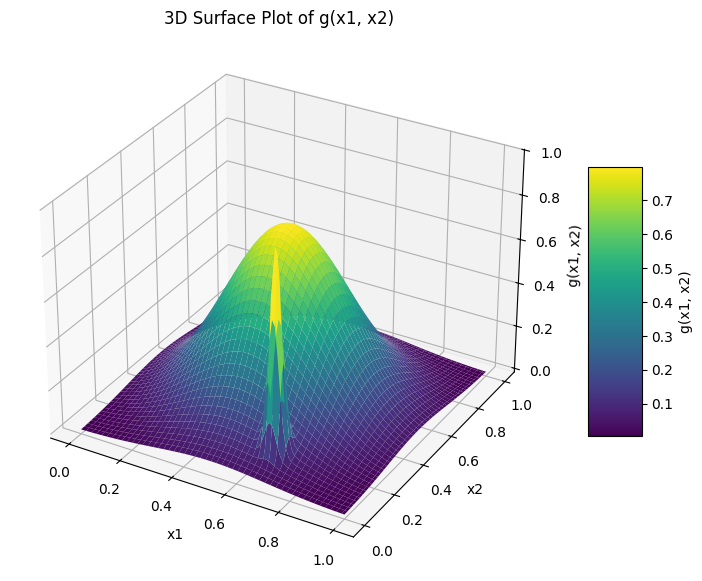

In [353]:
def plot_function(function):
    x1_lin = np.linspace(0, 1, 100)
    x2_lin = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(x1_lin, x2_lin)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    Z = function([X1, X2])
    surf = ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('g(x1, x2)')
    ax.set_title('3D Surface Plot of g(x1, x2)')
    fig.colorbar(surf, shrink=0.5, aspect=5, label='g(x1, x2)')
    plt.show()


plot_function(function_b)